In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
import matplotlib.pyplot as plt
import os
import json

from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img
from visualisation import visualize_results, visualize_results_interactive, visualize_projected, visualize_results_rays, visualize_results_mesh

from copy import deepcopy
import cv2 as cv

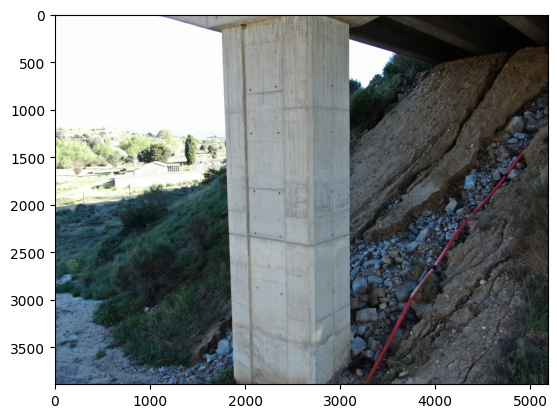

In [27]:
IMG_FOLDER_PATH = 'image_selection_data/P_1'
IMG_FORMAT = '.JPG'
POSES_FOLDER = 'poses'

image_name = 'DJI_20240417190632_0129_Z'

image_path = os.path.join(IMG_FOLDER_PATH, image_name + IMG_FORMAT) 
assert os.path.exists(image_path), "Image not found" 

pose_path = os.path.join(POSES_FOLDER, image_name + '.json') 
assert os.path.exists(pose_path), "Pose file not found" 

with open(pose_path) as json_file:
    pose_info = json.load(json_file)


camera_path = "cameras.json"
assert os.path.exists(camera_path), "Camera file not found" 

with open(camera_path) as json_file:
    cameras_info = json.load(json_file)

for i in cameras_info:
    if cameras_info[i]["id"] == pose_info["camera_id"]:
        camera_info = cameras_info[i]
    break

img = cv.imread(image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) 
plt.show()

In [28]:
MESH_PATH = 'image_selection_data/decimated_centered_textured_mesh.obj'

camera_matrix = np.float64(camera_info["matrix"])
distortion_coefficients = np.float64(camera_info["distortion_coefficients"])
rotation = np.float64(pose_info["rotation"]).reshape(3, 3)
center = np.float64(pose_info["center"]).reshape(3, 1)

pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix/10, int(camera_info["height"]*2), int(camera_info["width"]*2), pier)
# pier_cutted = pier_cutted
meshes = []
world_xyz = trimesh.creation.axis()
meshes.append(world_xyz)
camera_xyz = trimesh.creation.axis()
camera_xyz.vertices = (np.matmul(rotation.transpose(), camera_xyz.vertices.transpose()) + center).transpose()
meshes.append(camera_xyz)
meshes.append(pier_cutted)

scene = trimesh.Scene(meshes)
scene.show('notebook')


image shape (3888, 5184)


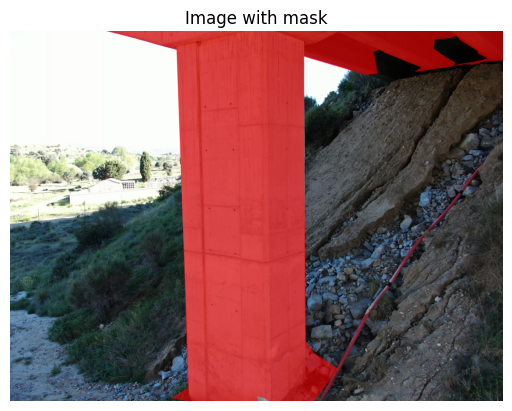

In [29]:
masks = create_masks_from_meshes([pier_cutted], img, rotation, center, camera_matrix, distortion_coefficients)

masks = masks[0]
print(f"image shape {masks.shape}")
plt.imshow(draw_mask_on_img(masks, img)) 
plt.axis('off') 
plt.title("Image with mask") 
plt.show()

In [30]:
def get_vertices_behind_camera(vertices, rotation, translation_cam):
    vertices = np.array(vertices, dtype=np.float64)
    rotation = np.array(rotation, dtype=np.float64)
    translation_cam = np.array(translation_cam, dtype=np.float64).squeeze()

    transform = np.eye(4, dtype=np.float64)
    transform[:3, :3] = rotation
    transform[:3, 3] = translation_cam
    homogeneous_vertices = np.hstack((vertices, np.ones((vertices.shape[0], 1))))
    camera_coords = np.dot(homogeneous_vertices, transform.T)
    behind_camera = camera_coords[:, 2] < 0

    return behind_camera


camera_matrix = np.float64(camera_matrix)
distortion_coefficients = np.float64(distortion_coefficients)
rotation = np.float64(rotation).reshape(3, 3)
center = np.float64(center).reshape(3, 1)

translation_cam = (-rotation @ center).reshape(3, 1)
projected_vertices, _ = cv.projectPoints(pier_cutted.vertices.view(np.ndarray).astype(np.float64), np.float64(rotation), np.float64(translation_cam), np.float64(camera_matrix), np.float64(distortion_coefficients))
projected_vertices = projected_vertices.squeeze() #.astype(np.int64)

behind_camera = get_vertices_behind_camera(
    pier_cutted.vertices.view(np.ndarray).astype(np.float64),
    np.float64(rotation),
    np.float64(translation_cam)
)

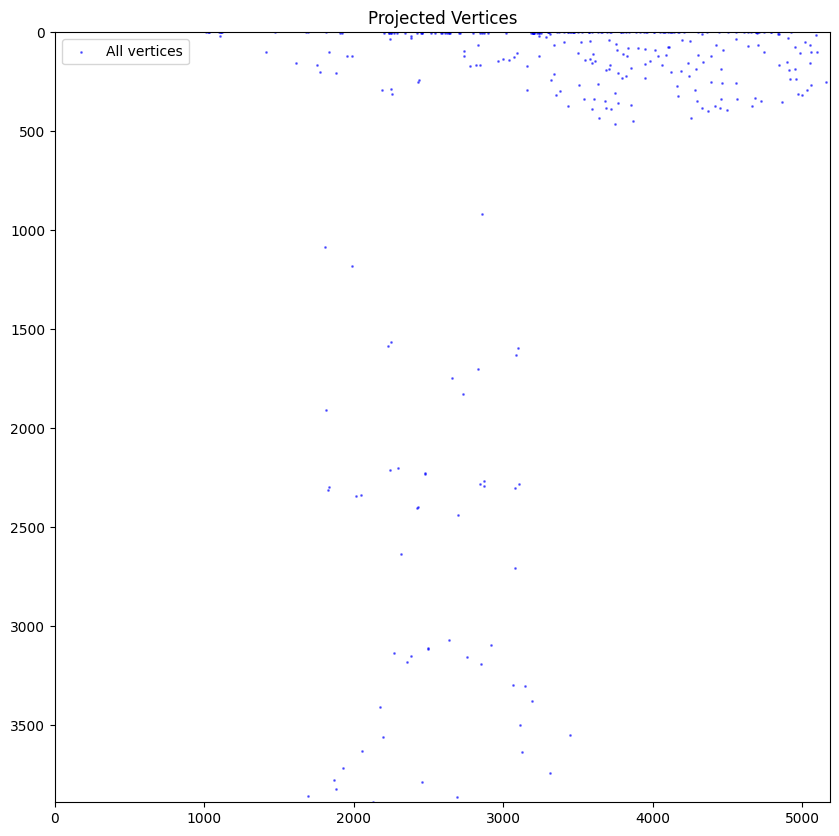

In [31]:
visualize_projected(projected_vertices, (camera_info["height"], camera_info["width"]))

In [32]:
image_size = (camera_info["height"], camera_info["width"])


print(f"Total vertices: {len((pier_cutted.vertices))}")
print(f"Vertices in image coordinates shape: {projected_vertices.shape}")
in_front_of_camera = ~behind_camera

within_x_bounds = (projected_vertices[:, 0] >= 0) & (projected_vertices[:, 0] < image_size[1])
within_y_bounds = (projected_vertices[:, 1] >= 0) & (projected_vertices[:, 1] < image_size[0])
within_image_bounds = within_x_bounds & within_y_bounds
potentially_visible = in_front_of_camera & within_image_bounds

potentially_visible = within_image_bounds
print(f"Vertices in front of camera: {np.sum(in_front_of_camera)}")
print(f"Vertices within image boundaries: {np.sum(within_image_bounds)}")
print(f"Potentially visible vertices: {np.sum(potentially_visible)}")
potential_indices = np.where(potentially_visible)[0]      


Total vertices: 398
Vertices in image coordinates shape: (398, 2)
Vertices in front of camera: 398
Vertices within image boundaries: 282
Potentially visible vertices: 282


In [33]:

vertices = pier_cutted.vertices.view(np.ndarray).astype(np.float64)
print('Total vertices', len(vertices))

vertices_projected = vertices[potential_indices]
backtrack_dict = {}

print('Projected vertices', len(vertices_projected))

rays_directions = vertices_projected - center.squeeze()
distances = np.linalg.norm(rays_directions, axis=1)
rays_directions /= distances.reshape(-1, 1)
rays_origins = np.tile(center.squeeze(), (len(rays_directions), 1))

locations, index_ray, index_tri = pier_cutted.ray.intersects_location(
    ray_origins=rays_origins,
    ray_directions=rays_directions,
    multiple_hits=False
)

any_hit = pier_cutted.ray.intersects_any(
    ray_origins=rays_origins,
    ray_directions=rays_directions
)

potential_indices_hits = np.where(any_hit)[0]
print('Ray hits',len(potential_indices_hits))

vertices_projected_hits = vertices_projected[potential_indices_hits]

ray_miss = np.abs(vertices_projected_hits - locations) # score to deside if vertice is visible
ray_miss = ray_miss < 0.01

visible = np.logical_and(ray_miss[:, 0], np.logical_and(ray_miss[:, 1], ray_miss[:, 2]))
print('Visible', sum(visible))

visible_indices = potential_indices[potential_indices_hits[visible]]
visible_vertices = vertices[visible_indices]
print('Visible vertices', len(visible_vertices))


Total vertices 398
Projected vertices 282
Ray hits 227
Visible 88
Visible vertices 88


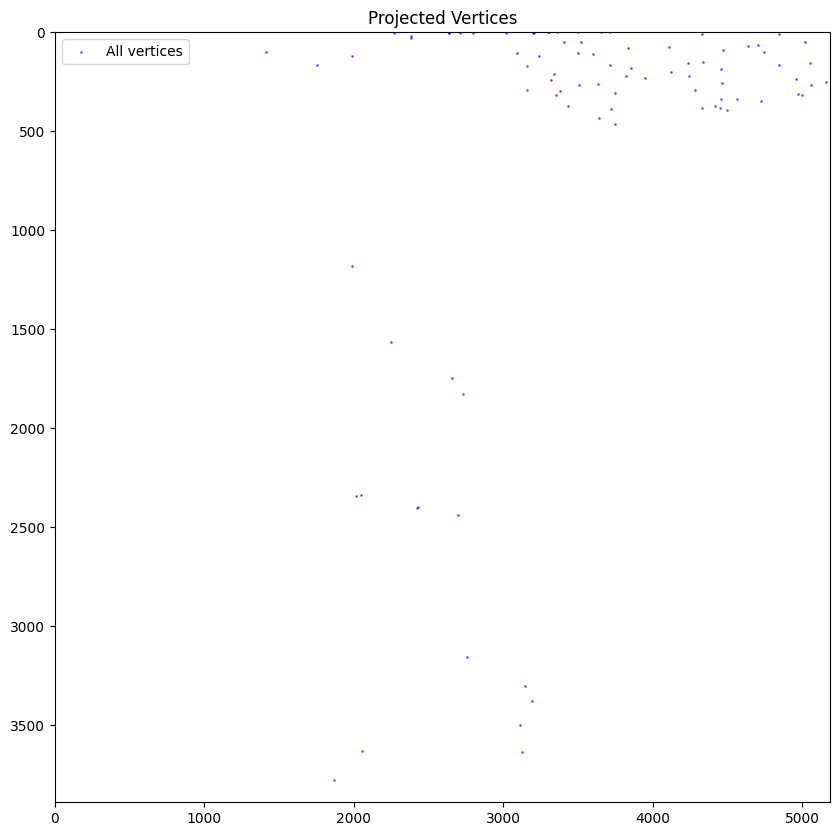

In [34]:
visualize_projected(projected_vertices[visible_indices], (camera_info["height"],  camera_info["width"]))

In [35]:
camera_position = center.squeeze()
# visualize_results_interactive(pier_cutted, visible_indices, camera_position, rotation, center)

In [38]:
visualize_results_rays(pier_cutted, visible_indices, camera_position, rotation, center,  rays_origins[potential_indices_hits[visible]], rays_directions[potential_indices_hits[visible]])

In [37]:
visualize_results_mesh(pier_cutted, visible_indices, camera_position, rotation, center,  rays_origins[potential_indices_hits[visible]], rays_directions[potential_indices_hits[visible]])

In [39]:
def find_isolated_selected_vertices(mesh, selected_indices):
    vertex_adjacency = mesh.vertex_adjacency_graph
    isolated_vertices = []
    for idx in selected_indices:
        neighbors = vertex_adjacency[idx]
        if not any(neighbor in selected_indices for neighbor in neighbors):
            isolated_vertices.append(idx)

    return isolated_vertices

isolated_visible_vertices = find_isolated_selected_vertices(pier_cutted, visible_indices)


In [40]:
isolated_visible_vertices

[43, 129, 233, 274, 278, 302, 313, 358, 367, 376]